In [1]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# pip install np_utils and then restart your terminal if you get error
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K


/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Declare constants which will be used while plotting the data
FS_AXIS_LABEL=14
FS_TITLE=17
FS_TICKS=12
FIG_WIDTH=20
ROW_HEIGHT=3
TEXT_SPACING=4

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# data_dir=os.path.join('..','input')
# data_dir=os.path.join('..','NumtaDB')
# data_dir=os.path.join('..','Numta-DB','input')
# data_dir=os.path.join('..','/home/hasib/Hasib/Others/NumtaDB_with_aug')

data_dir=os.path.join('..','/home/hasib/Hasib/Others/NumtaDB_with_aug')
print(os.listdir(data_dir))

['testing-d', 'testing-b', 'testing-augc', 'training-a', 'training-e', 'training-b', 'training-c', 'training-a.csv', 'training-d.csv', 'testing-f', 'training-d', 'testing-e', 'training-e.csv', 'training-c.csv', 'training-b.csv', 'testing-a', 'testing-auga', 'testing-c']


So there are 5 training datasets, 5 .csv files which contains the corresponding labels, and 8 testing datasets.

# Setting up path variables

Next, we are going to get the image filepaths.  I am using the `os.path.join()` function to create the filepaths instead of writing them down explicitly with a  filepath separator (`\\` for windows `/` for linux). This allows the notebook to run both in windows and linux environment without manually changing the filepath separator.  

In [4]:
os.path.join(data_dir,'training-a','*.png')

'/home/hasib/Hasib/Others/NumtaDB_with_aug/training-a/*.png'

For windows os the output will be  `'..\\input\\training-a\\*.png'`<br>
For linux os the output will be  `'../input/training-a/*.png'`

The  wildcard `*` is a character that can be used as a substitute for any of a class of characters in a search. The images generally have `.png` extension and some images in dataset `f`has `.JPG` extension. We are going get all the filepaths having `.png` and `.JPG` in their name using the `glob.glob()` function .

In [5]:
# training images
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))

paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e
# testing images
paths_test_a=glob.glob(os.path.join(data_dir,'testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.jpg'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-augc','*.png'))

paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

# training labels
path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

#display a path
print(path_label_train_a)

/home/hasib/Hasib/Others/NumtaDB_with_aug/training-a.csv


# Reading Image Data

In [8]:
path=paths_train_a[0]
img=cv2.imread(path) # cv2 stores image in BGR format
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # transforming to RGB format

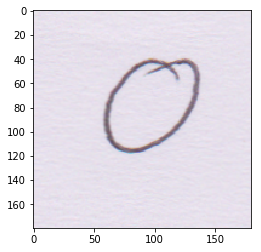

In [9]:
plt.imshow(img)
plt.show()

# Data Preprocessing

Before feeding the image to a NN various types of preprocessing needs to be done. 

## Resize

Resizing allows us to build a small NN.

In [11]:
RESIZE_DIM=28
img_rz=cv2.resize(img,(RESIZE_DIM,RESIZE_DIM),interpolation=cv2.INTER_AREA)

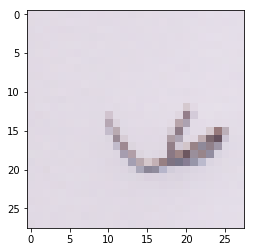

In [12]:
plt.imshow(img_rz)
plt.show()

## Rescale

Rescaling (dividing the pixel values by 255) limits the image pixels between a value of 0 to 1, this makes the neural network  computationally more stable. 
Placing image reading, resizing and rescaling in a function.

In [13]:
def get_data(path, resize_dim=RESIZE_DIM):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_rz=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
    img_rz_rs=img_rz/255
    return img_rz_rs

## Using data from only training set a

In [14]:
X_train_a=np.array([get_data(path) for path in paths_train_a])

In [15]:
X_train_a.shape

(19702, 28, 28, 3)

## Get label of images

We are going to use the pandas library to manipulate the label `.csv` files.

In [16]:
df = pd.read_csv(path_label_train_a) # store the execl in a pandas dataframe
df.head() # observe first five rows

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [17]:
df=df.set_index('filename') 
df.head() # observe first five rows

,original filename,scanid,digit,database name original,contributing team,database name
filename,,,,,,
a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


To get the label of an image, we need the image file name.

In [18]:
df.loc['a00000.png']['digit']

5

We need to separate the image name from the file path.

In [19]:
path=paths_train_a[0]
path

'/home/hasib/Hasib/Others/NumtaDB_with_aug/training-a/a04667.png'

Let's write a function that would get the filename from image filepaths.

In [20]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

In [21]:
get_key(path)

'a04667.png'

In [22]:
y_label_a=np.array([df.loc[get_key(path)]['digit'] for path in  paths_train_a])
y_train_a=to_categorical(y_label_a, 10)

## Train, Validation and Test set

Usually, the trainining set is split up into `train` and `validation` set. The model is trained using the train set and the performance is evaluated using the validation set. If the performance is not satisfactory the model is tinkered to get a better performance on the validation data. In this way the model actually overfits on the validation set. To get an estimate of its performance on unseen data we use the `test` data. In theory, test data should not be used to modify model parameters.

In [23]:
indices=list(range(len(X_train_a)))
np.random.seed(42)
np.random.shuffle(indices)

ind=int(len(indices)*0.80) # model will be trained with 80% of the training data
# train data
X_train=X_train_a[indices[:ind]] 
y_train=y_train_a[indices[:ind]]
# validation data
X_val=X_train_a[indices[-(len(indices)-ind):]] 
y_val=y_train_a[indices[-(len(indices)-ind):]]

# Model Architecture

Now we shall get familiar with some basic layers which crusial in building a Convolutional Neural Network.

The javasript and image contents used in this section are taken from Stanford CS class [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/)

## Dense layer

Below we see a regular neural network with an input layer, a hidden dense layer and an output layer. The input layer is our data and the output layer is our target. Notice that each neuron of the hidden layer is connected with every neuron of the incoming layer. Such a layer is called a `Dense` layer. 

![Neural Network with Dense hidden layer](assets/nn1/neural_net.jpeg)

## Convolutional layer

An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input.

![Neural Network with Convolutional layer](assets/cnn/depthcol.jpeg)

## Convolution Operation

Let's consider a convolutional layer with 2 filters. All the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows. The input volume is of size 5x5x3. In the CONV layer we have two filters of size 3×3, and they are applied with a stride of 2.  Moreover, notice that a padding of 1 pixel is applied to the input volume, making the outer border of the input volume zero. The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias.

In [22]:
from IPython.display import HTML
HTML('<iframe src="assets/conv-demo/index.html" width="100%" height="700px;" style="border:none;"></iframe>')

## ReLU

The rectified linear layer induces a nonlinearity in the values of the incoming layer. The function of ReLU can be summarized mathematically as $f(x) = max(x, 0)$ i.e. it only passes the values $x$ which are greater than zero.


![ReLU operation](assets/nn1/relu.jpeg)

## Maxpooling layer

The max pooling layer downsamples the input. This reduces computational cost due the reduction in dimension and provides translational invariance to the internal representation. 

![Maxpooling Operation](assets/cnn/maxpool.jpeg)

## Softmax layer

The softmax function squashes the outputs of each unit to be between 0 and 1 such that the total sum of the outputs is equal to 1. The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability that any of the classes are true.

![Softmax Example](assets/nn1/softmax_example.png)
Source: [Kulbear](https://github.com/Kulbear/deep-learning-nano-foundation/wiki/ReLU-and-Softmax-Activation-Functions)

The filter weights are updated to minimize a defined `loss function`. The updates are done using a form of `gradient descent` and the gradients are calculated using `backpropagation` algorithm. These concepts are not covered in this notebook

## Building a Convolutional Neural Network

In [24]:
# def get_model():
#     input_layer=Input(shape=(RESIZE_DIM,RESIZE_DIM,3))
#     x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
#     x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)

#     x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
#     x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)

#     x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
#     x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
#     x=Flatten()(x)
#     x=Dense(units=64)(x)
#     x=Dense(units=10)(x)    
#     output_layer=Activation('softmax')(x)
#     model=Model(inputs=input_layer,outputs=output_layer)
#     model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
#     return model
# model=get_model()
# model.summary()

def get_model():
    model=Sequential()
    model.add(Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu',input_shape=(RESIZE_DIM, RESIZE_DIM, 3)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(units=64))
    model.add(Dense(units=10))
    
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    return model
model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 8)         608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
__________

## Train and Validate

In [25]:
path_model='model_simple_keras_starter.h5' # save model at this location after each epoch

In [26]:
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=get_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=2, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 15761 samples, validate on 3941 samples
Epoch 1/2
15761/15761 [==============================] - 11s 729us/step - loss: 9.1632 - acc: 0.0985 - val_loss: 9.5702 - val_acc: 0.0985
Epoch 2/2
15761/15761 [==============================] - 11s 675us/step - loss: 9.6457 - acc: 0.1014 - val_loss: 9.5702 - val_acc: 0.0985


In [27]:
model.load_weights(path_model)

# Performance on Test set a

In [28]:
X_test_a=np.array([get_data(path) for path in paths_test_a])

In [29]:
predictions_prob=model.predict(X_test_a) 

In [30]:
X_sample=X_test_a[:40]
y_sample=predictions_prob[:40]
# y_true=y_train_a[:40]

In [31]:
def imshow_group(X,y=None,y_pred=None,n_per_row=10):
    '''helper function to visualize a group of images along with their categorical true labels (y) and prediction probabilities.
    Args:
        X: images
        y: categorical true labels
        y_pred: predicted class probabilities
        n_per_row: number of images per row to be plotted
    '''
    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+TEXT_SPACING
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=TEXT_SPACING
#             plt.text(img_dim/2, -4, 'true label: {}'.format(np.argmax(y[i])), 
#                      horizontalalignment='center',verticalalignment='center')
        plt.axis('off')
    plt.show()

    
    

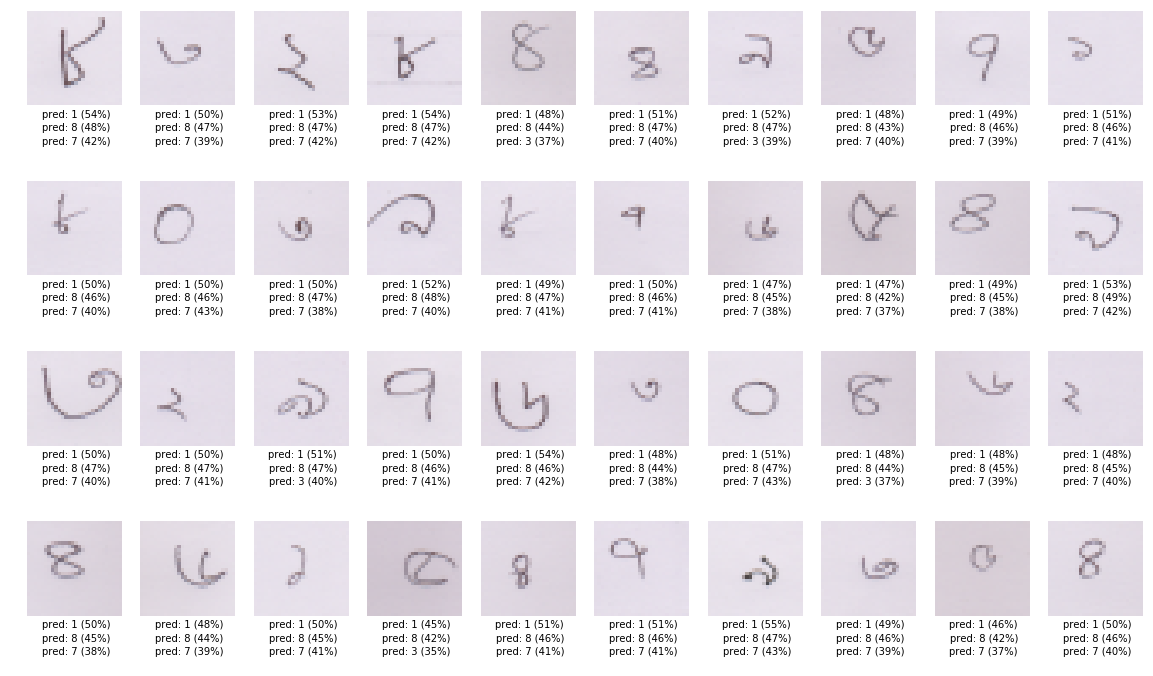

In [32]:
imshow_group(X=X_sample,y=None,y_pred=y_sample)

The performance is satisfactory considering the simplicity of the network and such little training time.

Let's observe it's performance on the augmented test set produced from dataset `a`.

# Performance on Test set auga

In [33]:
X_test_auga=np.array([get_data(path) for path in paths_test_auga])

In [34]:
predictions_prob=model.predict(X_test_auga) 

In [35]:
X_sample=X_test_auga[:40]
y_sample=predictions_prob[:40]
# y_true=y_train_a[:40]

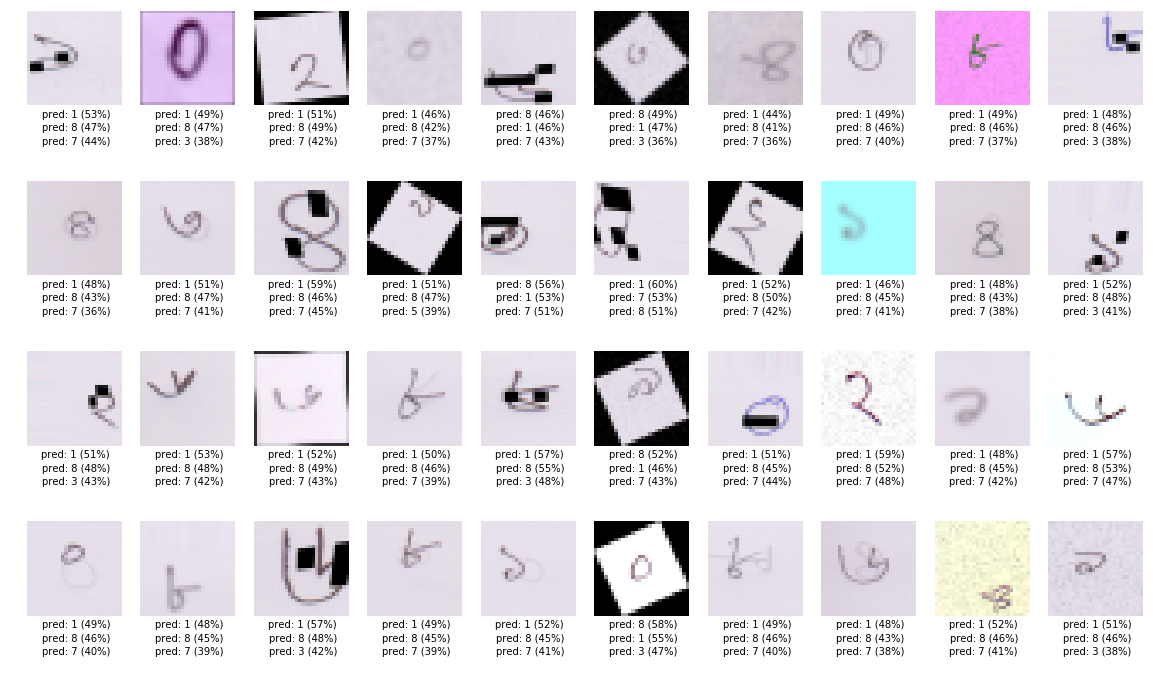

In [36]:
imshow_group(X=X_sample,y=None,y_pred=y_sample)

As expected, the CNN does not perform well on this augmented test set.

# Augmentation

## Augmentation example

In [39]:
from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(
         rotation_range=30,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.2,
         zoom_range=0.2,
         horizontal_flip=False,
         vertical_flip=False,
         fill_mode='nearest',
         )

count = 0
X_train_aug=[]
for train_batch, _ in datagen.flow(X_train, y_train, batch_size=1):
    X_train_aug.append(train_batch[0])
    count = count + 1
    if count ==40:  #len(paths_train_a) = 19720
        break
X_train_aug=np.array(X_train_aug)
print(X_train_aug.shape)

(40, 28, 28, 3)


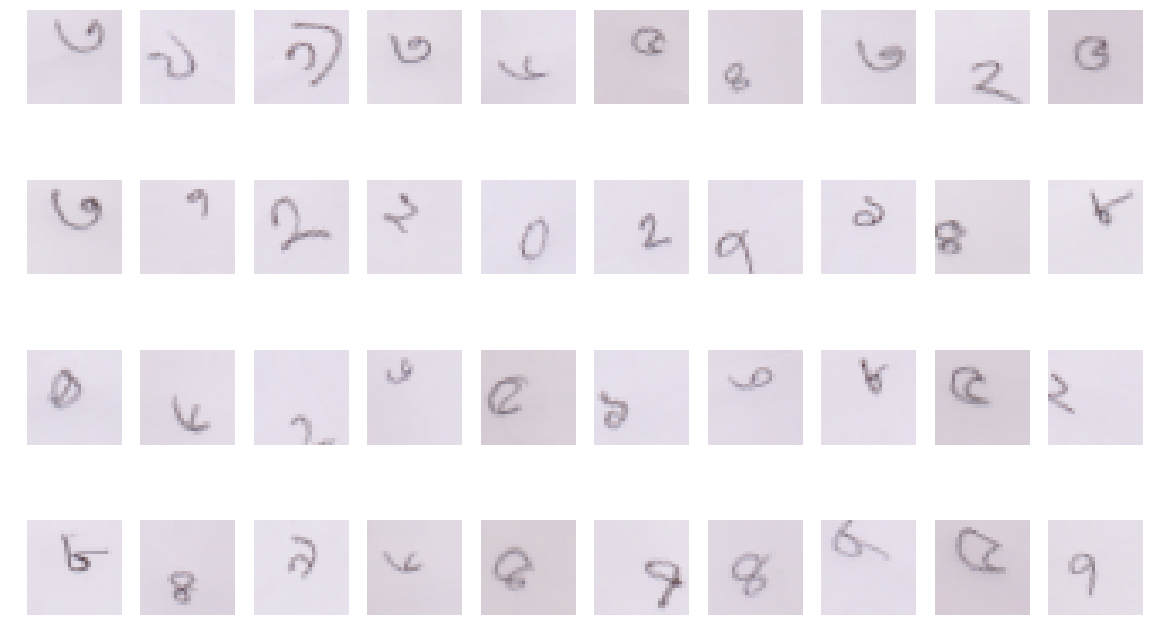

In [66]:
imshow_group(X_train_aug)

## Augmentation as a function

In [41]:
def data_aug(X_train,X_test,y_train,y_test,train_batch_size,test_batch_size):
    train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #rescale=1.0/255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')
    test_datagen = ImageDataGenerator()#rescale=1.0/255)
    train_batch = train_datagen.flow(X_train,y_train,batch_size=train_batch_size)
    test_batch = test_datagen.flow(X_test,y_test,batch_size=test_batch_size)
    return (train_batch,test_batch)

## Training on augmented data

In [43]:
import gc
gc.collect()
K.clear_session()
model = get_model()

# Call augmentation function
batch_size = 64
train_batch, val_batch = data_aug(X_train,X_val,y_train,y_val, batch_size, batch_size)

# Fit generator for Data Augmentation - UNCOMMENT THIS FOR DATA AUGMENTATION
batch_size = 64
epochs = 2

"""
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=2, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )
"""
history = model.fit_generator(train_batch, 
                              validation_data=val_batch, 
                              epochs=epochs, 
                              validation_steps= X_val.shape[0] // batch_size,
                              steps_per_epoch= X_train.shape[0] // batch_size, 
                              verbose=2
                             )

Epoch 1/2
 - 12s - loss: 7.2198 - acc: 0.0988 - val_loss: 8.1292 - val_acc: 0.1050
Epoch 2/2
 - 12s - loss: 8.0254 - acc: 0.0981 - val_loss: 8.1292 - val_acc: 0.1050


## Plot function

In [44]:
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

## Visualize the training/validation loss and accuracy

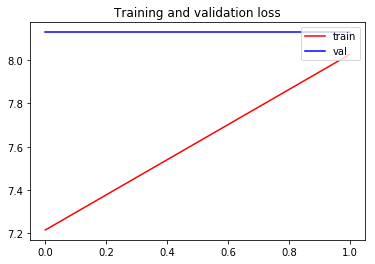

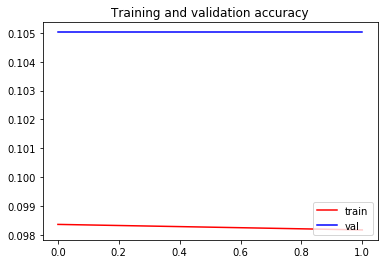

In [45]:
plot_loss_accu(history)

## Performance on Test set auga with Data Augmentation

In [46]:
predictions_prob=model.predict(X_test_auga) 

In [47]:
X_sample=X_test_auga[:40]
y_sample=predictions_prob[:40]
# y_true=y_train_a[:40]

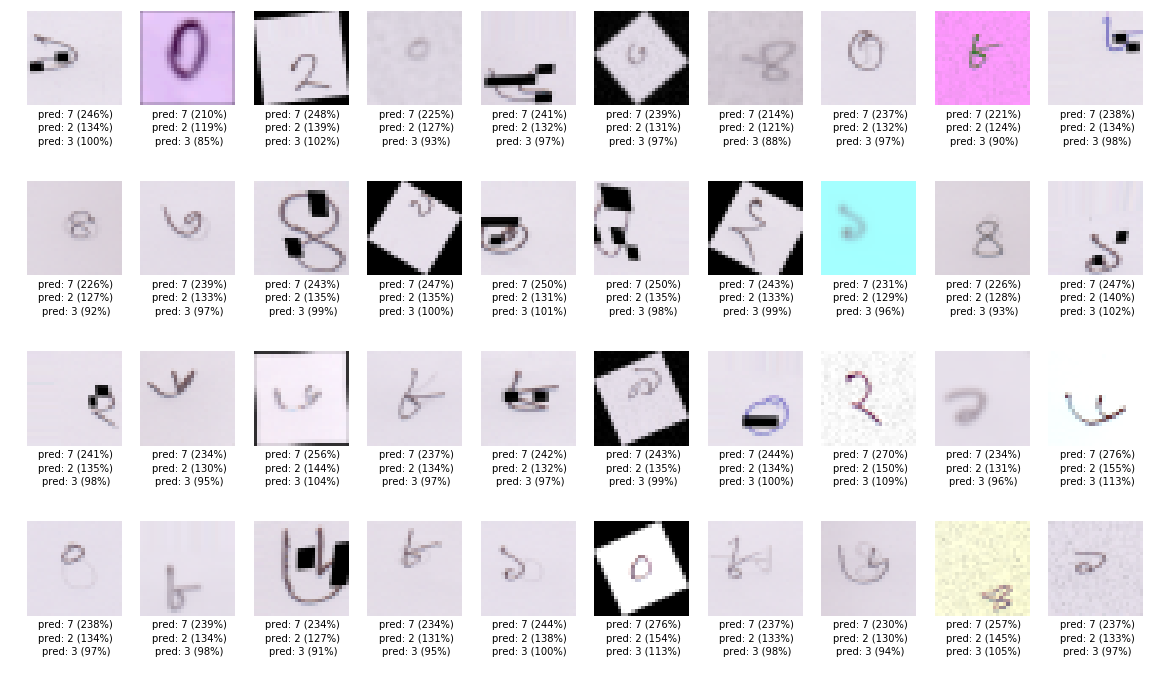

In [48]:
imshow_group(X=X_sample,y=None,y_pred=y_sample)

# Transfer Learning

In [50]:
X_train_a_48=np.array([get_data(path,resize_dim=48) for path in paths_train_a])
# train data
X_train_48=X_train_a_48[indices[:ind]] 
# validation data
X_val_48=X_train_a_48[indices[-(len(indices)-ind):]] 

In [51]:
from keras.applications.vgg16 import VGG16
def create_model_vgg16():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(48, 48, 3))
    X = base_model.output
    predictions = Dense(10, activation='softmax')(X)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [52]:
model = create_model_vgg16()
batch_size=16
epochs = 1
history =  model.fit(X_train_48, y_train, validation_data=(X_val_48, y_val), epochs=epochs, batch_size=batch_size, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [53]:
X_test_a_48=np.array([get_data(path,resize_dim=48) for path in paths_train_a])

### What's the performance on test auga? 

In [54]:
predictions_prob=model.predict(X_test_a_48) 

In [55]:
n_sample=200 #200
np.random.seed(42)
ind=np.random.randint(0,len(X_test_a_48), size=n_sample)

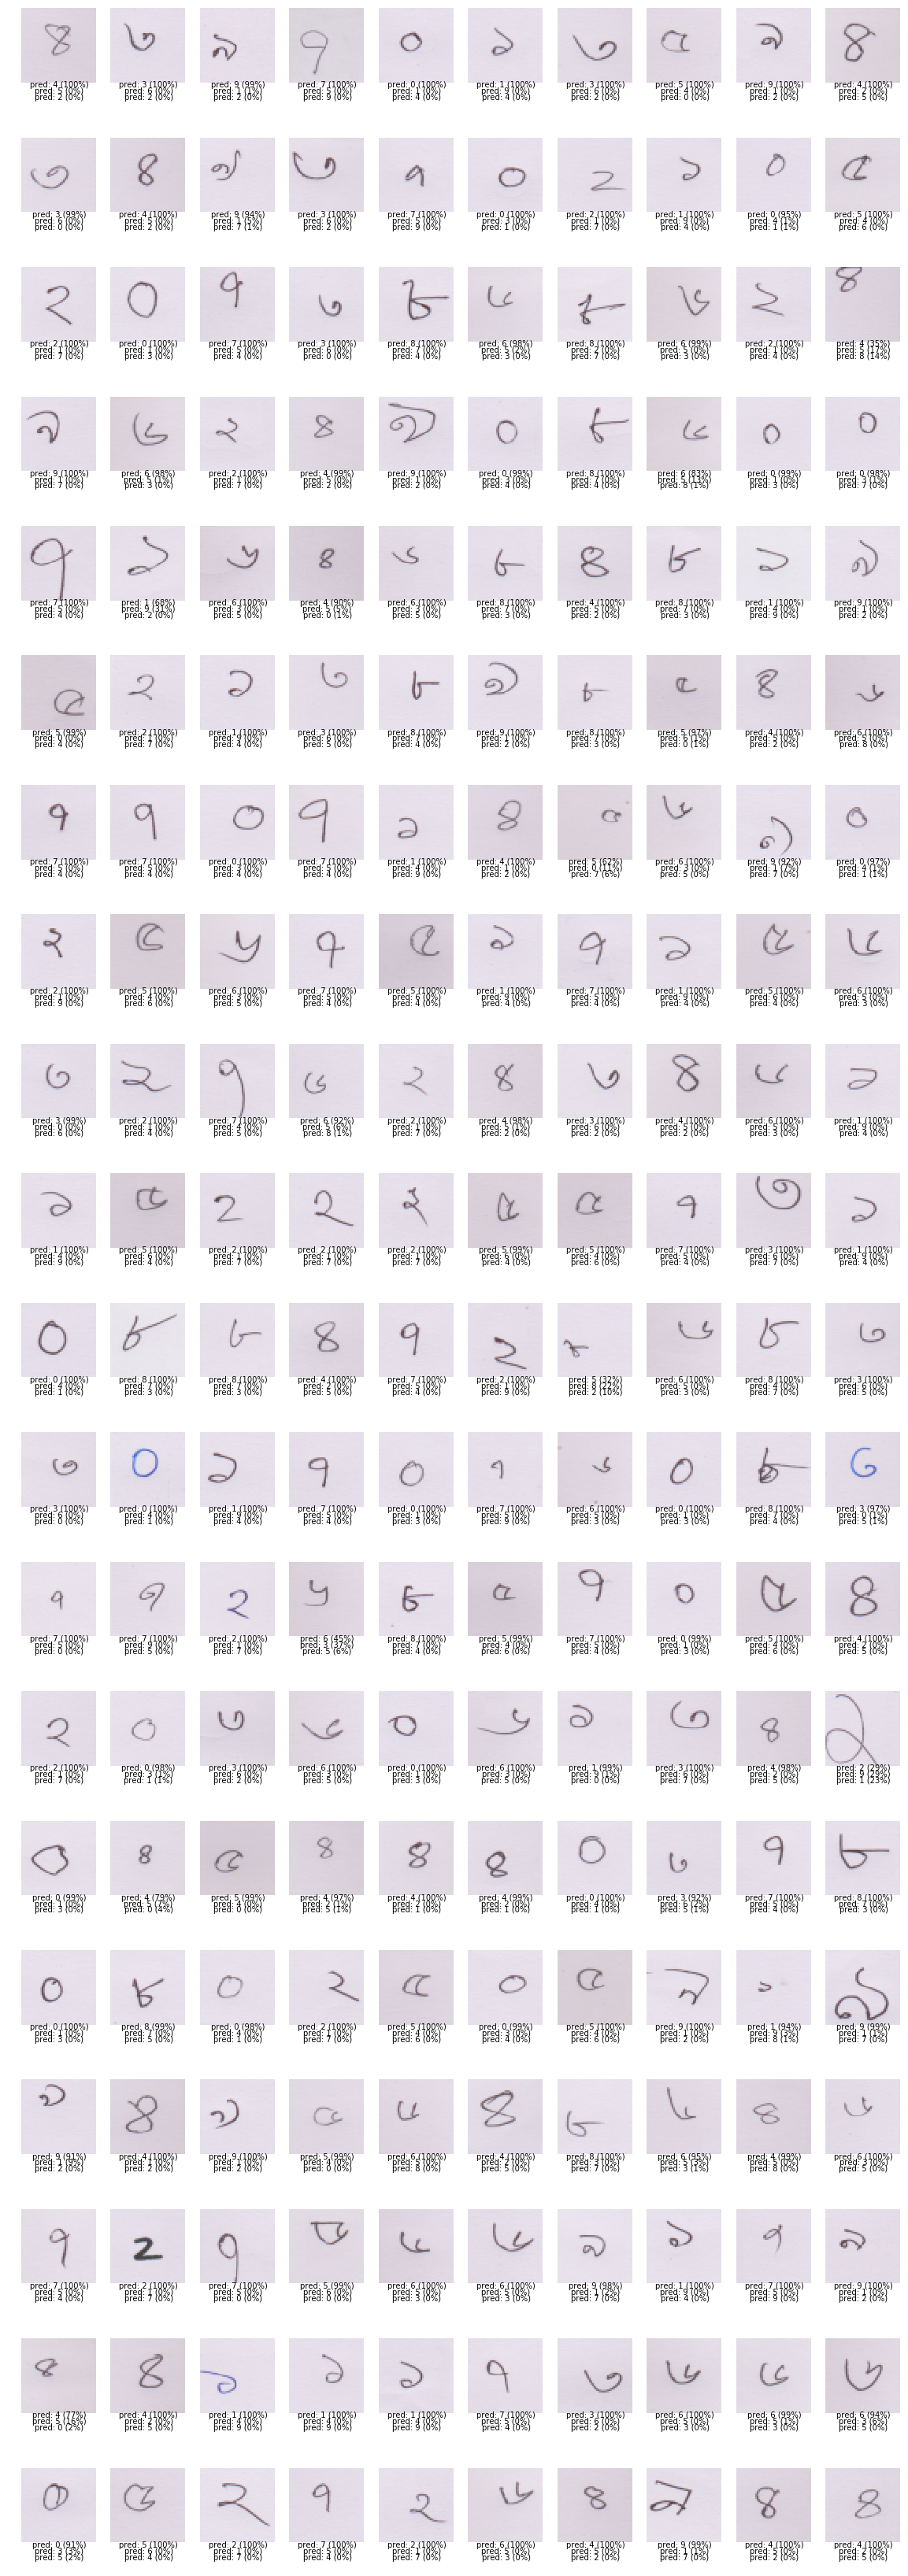

In [56]:
imshow_group(X=X_test_a_48[ind],y=None,y_pred=predictions_prob[ind])

In [57]:
labels=[np.argmax(pred) for pred in predictions_prob]

In [58]:
keys=[get_key(path) for path in paths_test_all ]

In [59]:
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [60]:
create_submission(predictions=labels,keys=keys,path='hasib_keras_TFrun_june_10.csv')

ValueError: Shape of passed values is (1, 19702), indices imply (1, 17350)